In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
num_param = 10
num_time = 200
num_node = 14300
num_var = 4

# interp1, 2 are the parameter values, starting from 0
interp1 = 4 # in reality, param no. interp1+1
interp2 = 5 # in reality, param no. interp2+1


n_epochs = 10000
n_epochs_latent=50
batch_size = 1
LR = 2e-5
Lv1_latent_dim = 128
Lv2_latent_dim = 128
epoch_1 = 15000

alpha = 0

In [10]:
f = np.zeros([num_param, num_time, Lv1_latent_dim])

for i in range(num_param):
    filename3 = 'latent_vectors_Lv1/latent_vector_p-s%d' %(i+1)
    temp = np.loadtxt(filename3)
    f[i,:,:] = np.loadtxt(filename3)

In [11]:
f.shape

(10, 200, 128)

## Scale latent codes from Lv 1.

In [12]:
maximum = np.amax(f)
minimum = np.amin(f)
mean = np.mean(f)
AT = maximum-minimum

f = f-mean
f = f/AT

print(maximum)
print(minimum)

257.713562
-196.918152


In [13]:
print(np.max(f))
print(np.min(f))

0.5685007783595442
-0.431499221640456


# Level 2, TVAE (Temporal VAE)

In [14]:
# Lv2_input = (num_param, num_time, Lv1 latent vector dim)

Lv2_input = f
Lv2_input.shape

(10, 200, 128)

In [15]:
#validate

Lv2_input_shape_decoder = Lv2_input.shape[1]

In [16]:
Lv2_input_shape = Lv2_input.shape[1:]

In [17]:
print(Lv2_input.shape)
print(Lv2_input_shape)

(10, 200, 128)
(200, 128)


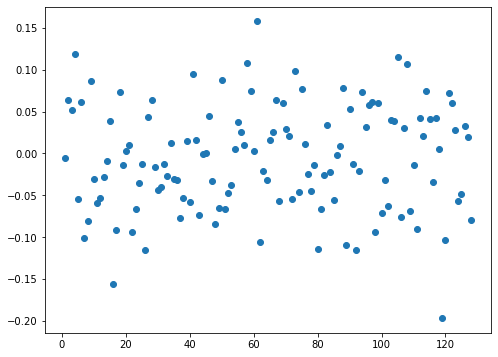

In [18]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)
plt.scatter(x_axis1, Lv2_input[0,0,:])

# Encoder

In [19]:
def encoder():
    x_input=layers.Input(shape=Lv2_input_shape)
    x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(256, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(128, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(64, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Flatten()(x)
    x=layers.Dense(Lv2_latent_dim)(x)
    
    #mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    #eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    #z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [x], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 128)]        0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 204, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 204, 256)          164096    
_________________________________________________________________
batch_normalization (BatchNo (None, 204, 256)          1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 204, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 204, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 204, 128)          1639

# Decoder

In [20]:
print(Lv2_latent_dim)
print(Lv2_input_shape_decoder)

128
200


In [21]:
def decoder():
    z_input=layers.Input(shape=(Lv2_latent_dim))
    
    z=layers.Dense(Lv2_input_shape_decoder*Lv2_latent_dim, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([Lv2_input_shape_decoder,Lv2_latent_dim])(z)
        
    z=layers.Conv1DTranspose(256, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(128, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(64, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)        
    
    z=layers.Dense(Lv1_latent_dim)(z)
    
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_mu=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_var=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
    
    ## I guess the 
    
    
    de_coder = tf.keras.models.Model(z_input, [z], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 25600)             3302400   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 25600)             0         
_________________________________________________________________
reshape (Reshape)            (None, 200, 128)          0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 200, 256)          131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 200, 256)          1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 200, 256)          0   

# loss computation

In [22]:
def compute_loss(real_img, fake_img):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum(tf.math.square(real_img) + tf.math.square(fake_img)))
    
    
    loss = reconstruction_error
    
    return loss

# VAE

In [23]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(real_img, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            fake_img = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(real_img, fake_img)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [24]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv2_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv2_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%1000==0):
            if((epoch+1)%1000==0):          
                filename1 = 'test_constrained_Lv2/decoder_%d.h5' % (epoch+1)
                filename2 = 'test_constrained_Lv2/encoder_%d.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

In [25]:
Lv2_input.shape
print(type(Lv2_input))

<class 'numpy.ndarray'>


# Warm up

In [26]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [27]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.999)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv2_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv2_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=losses.MeanSquaredError())

start = time.time()
vae.fit(Lv2_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/10000
10/10 [==============================] - 5s 9ms/step - loss: 0.5205
Epoch 2/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.5187
Epoch 3/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.5112
Epoch 4/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.5137
Epoch 5/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.5041
Epoch 6/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.5005
Epoch 7/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4993
Epoch 8/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.4934
Epoch 9/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.4947
Epoch 10/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4930
Epoch 11/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.4887
Epoch 12/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.4784
Epoch 13/100

10/10 [==============================] - 0s 9ms/step - loss: 0.0763
Epoch 100/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0753
Epoch 101/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0736
Epoch 102/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0741
Epoch 103/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0726
Epoch 104/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0717
Epoch 105/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0718
Epoch 106/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0699
Epoch 107/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0686
Epoch 108/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0682
Epoch 109/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0682
Epoch 110/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0670
Epoch 11

10/10 [==============================] - 0s 9ms/step - loss: 0.0391
Epoch 197/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0389
Epoch 198/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0401
Epoch 199/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0393
Epoch 200/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0386
Epoch 201/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0380
Epoch 202/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0392
Epoch 203/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0371
Epoch 204/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0385
Epoch 205/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0382
Epoch 206/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0374
Epoch 207/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0372
Epoch 20

10/10 [==============================] - 0s 8ms/step - loss: 0.0336
Epoch 294/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0326
Epoch 295/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0326
Epoch 296/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0317
Epoch 297/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0323
Epoch 298/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0318
Epoch 299/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0330
Epoch 300/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0323
Epoch 301/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0317
Epoch 302/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0325
Epoch 303/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0320
Epoch 304/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0309
Epoch

10/10 [==============================] - 0s 8ms/step - loss: 0.0282
Epoch 391/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0283
Epoch 392/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0274
Epoch 393/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0278
Epoch 394/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0285
Epoch 395/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0286
Epoch 396/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0280
Epoch 397/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0281
Epoch 398/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0288
Epoch 399/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 400/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0277
Epoch 401/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0281
Epoch 40

10/10 [==============================] - 0s 7ms/step - loss: 0.0266
Epoch 488/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0256
Epoch 489/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0252
Epoch 490/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0245
Epoch 491/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0249
Epoch 492/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0249
Epoch 493/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0252
Epoch 494/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0253
Epoch 495/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0257
Epoch 496/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0256
Epoch 497/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0247
Epoch 498/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0256
Epoch 49

10/10 [==============================] - 0s 7ms/step - loss: 0.0224
Epoch 585/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0232
Epoch 586/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0223
Epoch 587/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0226
Epoch 588/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0233
Epoch 589/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0232
Epoch 590/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0232
Epoch 591/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0227
Epoch 592/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0228
Epoch 593/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0229
Epoch 594/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0226
Epoch 595/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0224
Epoch 5

10/10 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 682/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0211
Epoch 683/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0203
Epoch 684/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0205
Epoch 685/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0202
Epoch 686/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0205
Epoch 687/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0196
Epoch 688/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0206
Epoch 689/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0202
Epoch 690/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0207
Epoch 691/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0205
Epoch 692/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0204
Epoch 69

10/10 [==============================] - 0s 8ms/step - loss: 0.0185
Epoch 779/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0188
Epoch 780/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0189
Epoch 781/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0188
Epoch 782/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 783/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0186
Epoch 784/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0185
Epoch 785/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0185
Epoch 786/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0187
Epoch 787/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0187
Epoch 788/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0185
Epoch 789/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0177
Epoch 

10/10 [==============================] - 0s 7ms/step - loss: 0.0165
Epoch 876/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0165
Epoch 877/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0173
Epoch 878/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0170
Epoch 879/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0166
Epoch 880/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0170
Epoch 881/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 882/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0172
Epoch 883/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0171
Epoch 884/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0172
Epoch 885/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0172
Epoch 886/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0165
Epoch 8

10/10 [==============================] - 0s 7ms/step - loss: 0.0156
Epoch 973/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0162
Epoch 974/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0151
Epoch 975/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0158
Epoch 976/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0154
Epoch 977/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0157
Epoch 978/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0154
Epoch 979/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0156
Epoch 980/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 981/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0155
Epoch 982/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0155
Epoch 983/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0155
Epoch 98

10/10 [==============================] - 0s 9ms/step - loss: 0.0145
Epoch 1065/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0144
Epoch 1066/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0148
Epoch 1067/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0138
Epoch 1068/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0144
Epoch 1069/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0147
Epoch 1070/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0140
Epoch 1071/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0149
Epoch 1072/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0143
Epoch 1073/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0144
Epoch 1074/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0148
Epoch 1075/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.01

10/10 [==============================] - 0s 8ms/step - loss: 0.0131
Epoch 1161/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0135
Epoch 1162/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0131
Epoch 1163/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 1164/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0140
Epoch 1165/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0133
Epoch 1166/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0133
Epoch 1167/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 1168/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0135
Epoch 1169/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 1170/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0133
Epoch 1171/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.01

10/10 [==============================] - 0s 8ms/step - loss: 0.0122
Epoch 1257/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0119
Epoch 1258/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0121
Epoch 1259/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0119
Epoch 1260/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0119
Epoch 1261/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0124
Epoch 1262/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0122
Epoch 1263/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0124
Epoch 1264/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0119
Epoch 1265/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0121
Epoch 1266/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0123
Epoch 1267/10000
10/10 [==============================] - 0s 10ms/step - loss: 0

10/10 [==============================] - 0s 8ms/step - loss: 0.0114
Epoch 1353/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0115
Epoch 1354/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0115
Epoch 1355/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0110
Epoch 1356/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0114
Epoch 1357/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0115
Epoch 1358/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0113
Epoch 1359/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0107
Epoch 1360/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0119
Epoch 1361/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0113
Epoch 1362/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0112
Epoch 1363/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0106
Epoch 1449/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0109
Epoch 1450/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0106
Epoch 1451/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0101
Epoch 1452/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0103
Epoch 1453/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0102
Epoch 1454/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0105
Epoch 1455/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0101
Epoch 1456/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0102
Epoch 1457/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0108
Epoch 1458/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0105
Epoch 1459/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.01

10/10 [==============================] - 0s 9ms/step - loss: 0.0099
Epoch 1545/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0100
Epoch 1546/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 1547/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0097
Epoch 1548/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 1549/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0098
Epoch 1550/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0104
Epoch 1551/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0096
Epoch 1552/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 1553/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 1554/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0099
Epoch 1555/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0091
Epoch 1641/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 1642/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0091
Epoch 1643/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 1644/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 1645/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0087
Epoch 1646/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0091
Epoch 1647/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0092
Epoch 1648/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0092
Epoch 1649/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 1650/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0089
Epoch 1651/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0

10/10 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 1737/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0084
Epoch 1738/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0085
Epoch 1739/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 1740/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0083
Epoch 1741/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0082
Epoch 1742/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0085
Epoch 1743/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 1744/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0083
Epoch 1745/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0082
Epoch 1746/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0081
Epoch 1747/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0

10/10 [==============================] - 0s 7ms/step - loss: 0.0079
Epoch 1833/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0079
Epoch 1834/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0080
Epoch 1835/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0077
Epoch 1836/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0078
Epoch 1837/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0076
Epoch 1838/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0078
Epoch 1839/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0077
Epoch 1840/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0077
Epoch 1841/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0074
Epoch 1842/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0078
Epoch 1843/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 7ms/step - loss: 0.0073
Epoch 1929/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0071
Epoch 1930/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0072
Epoch 1931/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0070
Epoch 1932/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0072
Epoch 1933/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0073
Epoch 1934/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 1935/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0073
Epoch 1936/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0070
Epoch 1937/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0070
Epoch 1938/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0071
Epoch 1939/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0067
Epoch 2021/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0067
Epoch 2022/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0066
Epoch 2023/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0064
Epoch 2024/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0065
Epoch 2025/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0065
Epoch 2026/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0067
Epoch 2027/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0064
Epoch 2028/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0068
Epoch 2029/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0066
Epoch 2030/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0067
Epoch 2031/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 9ms/step - loss: 0.0064
Epoch 2117/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0063
Epoch 2118/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 2119/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 2120/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 2121/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 2122/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 2123/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 2124/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 2125/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0061
Epoch 2126/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 2127/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 2213/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0056
Epoch 2214/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 2215/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 2216/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 2217/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 2218/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0057
Epoch 2219/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 2220/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 2221/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 2222/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0056
Epoch 2223/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 2309/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 2310/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 2311/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 2312/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0052
Epoch 2313/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0052
Epoch 2314/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0052
Epoch 2315/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0051
Epoch 2316/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 2317/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0052
Epoch 2318/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 2319/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0050
Epoch 2405/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0049
Epoch 2406/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0049
Epoch 2407/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0048
Epoch 2408/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 2409/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0050
Epoch 2410/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 2411/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0048
Epoch 2412/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 2413/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 2414/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 2415/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0046
Epoch 2501/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 2502/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 2503/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0044
Epoch 2504/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0044
Epoch 2505/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0045
Epoch 2506/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 2507/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 2508/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0044
Epoch 2509/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0044
Epoch 2510/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 2511/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.00

10/10 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 2597/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0041
Epoch 2598/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0041
Epoch 2599/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0041
Epoch 2600/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 2601/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 2602/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 2603/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 2604/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 2605/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 2606/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 2607/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0039
Epoch 2693/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 2694/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0037
Epoch 2695/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0038
Epoch 2696/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0037
Epoch 2697/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0038
Epoch 2698/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0040
Epoch 2699/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0038
Epoch 2700/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 2701/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 2702/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0038
Epoch 2703/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 2789/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0037
Epoch 2790/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 2791/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 2792/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 2793/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 2794/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 2795/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 2796/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 2797/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 2798/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 2799/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 2885/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 2886/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 2887/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 2888/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 2889/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 2890/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 2891/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 2892/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 2893/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 2894/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 2895/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0031
Epoch 2981/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 2982/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0030
Epoch 2983/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2984/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 2985/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 2986/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0030
Epoch 2987/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 2988/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0030
Epoch 2989/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2990/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 2991/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 3073/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 3074/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0029
Epoch 3075/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 3076/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 3077/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0030
Epoch 3078/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 3079/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 3080/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 3081/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 3082/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 3083/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 3169/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 3170/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 3171/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 3172/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 3173/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 3174/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 3175/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0026
Epoch 3176/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 3177/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 3178/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0026
Epoch 3179/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0

10/10 [==============================] - 0s 7ms/step - loss: 0.0026
Epoch 3265/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 3266/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0024
Epoch 3267/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 3268/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0024
Epoch 3269/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 3270/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 3271/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 3272/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 3273/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0025
Epoch 3274/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 3275/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.

10/10 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 3361/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 3362/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 3363/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 3364/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 3365/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 3366/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 3367/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 3368/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0023
Epoch 3369/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 3370/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 3371/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3457/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3458/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3459/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0022
Epoch 3460/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3461/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0022
Epoch 3462/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3463/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3464/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3465/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3466/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 3467/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 3553/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 3554/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 3555/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 3556/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 3557/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 3558/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0021
Epoch 3559/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3560/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3561/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 3562/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 3563/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0

10/10 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 3649/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 3650/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0022
Epoch 3651/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 3652/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 3653/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3654/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 3655/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3656/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 3657/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 3658/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 3659/10000
10/10 [==============================] - 0s 10ms/step - loss: 0

10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 3745/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 3746/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 3747/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 3748/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 3749/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 3750/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 3751/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3752/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 3753/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 3754/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 3755/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 3841/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 3842/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3843/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 3844/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3845/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 3846/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 3847/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 3848/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 3849/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 3850/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 3851/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 3937/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 3938/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 3939/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 3940/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 3941/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 3942/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 3943/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 3944/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 3945/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0022
Epoch 3946/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 3947/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4029/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4030/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4031/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 4032/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4033/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 4034/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4035/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4036/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4037/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4038/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4039/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4125/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4126/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4127/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4128/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4129/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4130/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4131/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4132/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4133/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4134/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 4135/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4221/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4222/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 4223/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4224/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4225/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4226/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 4227/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4228/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 4229/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 4230/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4231/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4317/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4318/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4319/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 4320/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4321/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4322/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4323/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4324/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 4325/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4326/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4327/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4413/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4414/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 4415/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4416/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 4417/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4418/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 4419/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4420/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4421/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4422/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4423/10000
10/10 [==============================] - 0s 10ms/step - loss: 0

10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4509/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4510/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4511/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4512/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4513/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4514/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4515/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4516/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4517/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4518/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4519/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4605/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4606/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 4607/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4608/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4609/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4610/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4611/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4612/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4613/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 4614/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4615/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4701/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4702/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4703/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4704/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4705/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4706/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4707/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4708/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4709/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4710/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4711/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4797/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4798/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4799/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4800/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4801/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4802/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 4803/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4804/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 4805/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4806/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4807/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 4893/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4894/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4895/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4896/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4897/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4898/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4899/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4900/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4901/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4902/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4903/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 4989/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 4990/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4991/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4992/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4993/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4994/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 4995/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 4996/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4997/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 4998/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 4999/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5081/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 5082/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5083/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 5084/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5085/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5086/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 5087/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5088/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5089/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 5090/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5091/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 5177/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5178/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5179/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5180/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5181/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5182/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5183/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5184/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 5185/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 5186/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5187/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 5273/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 5274/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5275/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5276/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5277/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5278/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5279/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 5280/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5281/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5282/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5283/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5369/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5370/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5371/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5372/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5373/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5374/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 5375/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5376/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5377/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5378/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5379/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5465/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5466/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5467/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5468/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5469/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5470/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5471/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5472/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5473/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 5474/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 5475/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5561/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 5562/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5563/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5564/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 5565/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 5566/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5567/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5568/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5569/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 5570/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5571/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0

10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 5657/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5658/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5659/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5660/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5661/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5662/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5663/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5664/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5665/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5666/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5667/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 5753/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 5754/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 5755/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5756/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 5757/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5758/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5759/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5760/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5761/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5762/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 5763/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5849/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 5850/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5851/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5852/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5853/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5854/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 5855/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5856/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 5857/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 5858/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5859/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5945/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5946/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5947/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 5948/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5949/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5950/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5951/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 5952/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 5953/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5954/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 5955/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 6037/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 6038/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6039/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6040/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 6041/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 6042/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6043/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 6044/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 6045/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6046/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6047/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6133/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6134/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6135/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6136/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6137/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 6138/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6139/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 6140/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 6141/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 6142/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6143/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6229/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 6230/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 6231/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6232/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6233/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 6234/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6235/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6236/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6237/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6238/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 6239/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6325/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6326/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 6327/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 6328/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6329/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 6330/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6331/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 6332/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 6333/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6334/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 6335/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0

10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6421/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 6422/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6423/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 6424/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6425/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6426/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6427/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6428/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6429/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6430/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6431/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0

10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6517/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6518/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6519/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 6520/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6521/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 6522/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6523/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6524/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6525/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6526/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6527/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 6613/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6614/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 6615/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6616/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6617/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6618/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 6619/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6620/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6621/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6622/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6623/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6709/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 6710/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6711/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 6712/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6713/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 6714/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 6715/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6716/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6717/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6718/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6719/10000
10/10 [==============================] - 0s 7ms/step - loss: 0

10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6805/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 6806/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6807/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6808/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6809/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6810/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 6811/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 6812/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6813/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 6814/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6815/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0

10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 6901/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6902/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 6903/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6904/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6905/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6906/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6907/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6908/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6909/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6910/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6911/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6997/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6998/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 6999/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 7000/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7001/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7002/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7003/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 7004/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7005/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7006/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 7007/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7089/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7090/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 7091/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7092/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 7093/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 7094/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7095/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7096/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7097/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7098/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7099/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.00

10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7185/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7186/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7187/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7188/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7189/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7190/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7191/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7192/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7193/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 7194/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7195/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7281/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7282/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7283/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7284/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7285/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 7286/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7287/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7288/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7289/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7290/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 7291/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7377/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 7378/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7379/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7380/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7381/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7382/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7383/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7384/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 7385/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7386/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7387/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 7473/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7474/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7475/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7476/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7477/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7478/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7479/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7480/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 7481/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7482/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 7483/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.

10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7569/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7570/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7571/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 7572/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 7573/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7574/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7575/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 7576/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7577/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7578/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 7579/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7665/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 7666/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7667/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7668/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7669/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7670/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7671/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7672/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7673/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7674/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7675/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7761/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 7762/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 7763/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7764/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7765/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 7766/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 7767/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7768/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7769/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7770/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7771/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7857/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7858/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 7859/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7860/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 7861/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7862/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7863/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7864/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7865/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7866/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7867/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7953/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7954/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7955/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7956/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 7957/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 7958/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7959/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 7960/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 7961/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7962/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 7963/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8045/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 8046/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8047/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8048/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8049/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8050/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8051/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8052/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8053/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8054/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8055/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8141/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8142/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8143/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8144/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8145/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8146/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 8147/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8148/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 8149/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8150/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8151/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 8237/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8238/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 8239/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8240/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 8241/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8242/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 8243/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0018
Epoch 8244/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8245/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8246/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8247/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8333/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8334/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 8335/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8336/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8337/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 8338/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8339/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 8340/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8341/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8342/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8343/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8429/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8430/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8431/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8432/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8433/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8434/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8435/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8436/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8437/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8438/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8439/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 8525/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 8526/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8527/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 8528/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8529/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 8530/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8531/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 8532/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8533/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 8534/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8535/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.

10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8621/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8622/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 8623/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8624/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8625/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8626/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8627/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 8628/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 8629/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 8630/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8631/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8717/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8718/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8719/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8720/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8721/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8722/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8723/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8724/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8725/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8726/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8727/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8813/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8814/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 8815/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 8816/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8817/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 8818/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8819/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8820/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8821/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8822/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0018
Epoch 8823/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.

10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8909/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8910/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8911/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 8912/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8913/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 8914/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8915/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8916/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 8917/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8918/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8919/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.00

Epoch 9001/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9002/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9003/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9004/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9005/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9006/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9007/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9008/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9009/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9010/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9011/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9012/10000
10/10 [==============================] - 0s 8ms/

10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9098/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9099/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9100/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9101/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9102/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9103/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9104/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 9105/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 9106/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9107/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9108/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.

10/10 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 9194/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 9195/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9196/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 9197/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 9198/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9199/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 9200/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 9201/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9202/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9203/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 9204/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 9290/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9291/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 9292/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 9293/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9294/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9295/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9296/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 9297/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9298/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9299/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9300/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9386/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 9387/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9388/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 9389/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9390/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9391/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9392/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 9393/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9394/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9395/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9396/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0

10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9482/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9483/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9484/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9485/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9486/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9487/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9488/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9489/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9490/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9491/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9492/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.00

10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9578/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9579/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9580/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 9581/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 9582/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9583/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9584/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9585/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 9586/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9587/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9588/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.

10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 9674/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9675/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9676/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9677/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9678/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 9679/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9680/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9681/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9682/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9683/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9684/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9770/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 9771/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9772/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9773/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9774/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9775/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9776/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9777/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9778/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9779/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9780/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0

10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9866/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9867/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 9868/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9869/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9870/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9871/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9872/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9873/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9874/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9875/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9876/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.00

10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9962/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 9963/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9964/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9965/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9966/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9967/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9968/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 9969/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9970/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 9971/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9972/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.00

# Acquire latent vectors

In [28]:
del Encoder
del Decoder

FOM_data = Lv2_input
FOM_data.shape

(10, 200, 128)

In [29]:

epoch = n_epochs
filename1='test_constrained_Lv2/encoder_%d.h5' % (n_epochs)
filename2='test_constrained_Lv2/decoder_%d.h5' % (n_epochs)
Encoder = load_model(filename1)
Encoder.summary()
Decoder = load_model(filename2)
Decoder.summary()


Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 128)]        0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 204, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 204, 256)          164096    
_________________________________________________________________
batch_normalization (BatchNo (None, 204, 256)          1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 204, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 204, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 204, 128)          1639

In [30]:
temp_lv2 = np.zeros([1,Lv2_input.shape[1],Lv2_input.shape[2]])
Lv2_latent = np.zeros([num_param, Lv2_latent_dim])

for i in range(num_param):
    temp_lv2[0,:,:] = Lv2_input[i,:,:]
        
    temp3= Encoder(temp_lv2, training=False) # Encoder output shape : mu, sigma, latent_vector = Encoder(x_train, training=False)
        
    Lv2_latent[i,:] = np.asarray(temp3)[0,:]

In [32]:
Lv2_latent.shape

(10, 128)

In [33]:
latent_vectors = np.zeros([Lv2_latent.shape[0],Lv2_latent.shape[1]])

latent_vectors = Lv2_latent

In [34]:
print(Lv2_latent.shape)

(10, 128)


In [35]:
latent_vectors

array([[ 14.79728031,  15.63015747, -12.26738644, ...,  16.54426384,
          2.71548915,   1.21791005],
       [  0.36747643,  15.80601692,  -2.32018471, ...,  18.66604996,
         -5.94623899,  -2.95991826],
       [ -1.9314009 ,   0.76879293,  -4.10143757, ...,  15.92378902,
          7.87456656,  -1.60206676],
       ...,
       [  5.67960119, -10.09450626, -14.56889153, ...,  -0.43951967,
          5.14540386,  18.9978447 ],
       [  1.76526701, -22.77172661, -19.41284561, ...,   2.67506814,
         -0.34743339,  10.79172325],
       [  1.59750462, -20.75690079, -11.14503288, ...,   4.39337778,
          4.71747208,   4.87124872]])

In [36]:
x_axis = np.linspace(1,Lv2_latent.shape[1],Lv2_latent.shape[1])

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128.])

# Output latent vectors to file,

In [37]:
# Save latent vectors for each parameter...

filename3 = 'latent_vectors_Lv2/latent_vector'
np.savetxt(filename3, Lv2_latent, fmt = '%f')

# Verify the accuracy of current VAE

In [38]:
# Lv2_input : num_param, num_time, 128

Lv2_input.shape

(10, 200, 128)

In [39]:
validate = Lv2_input[0,:,:]
validate.shape

(200, 128)

In [40]:
latent_val = np.zeros([1, Lv2_latent_dim])

latent_val[0,:] = Lv2_latent[0,:]

In [41]:
latent_val.shape

(1, 128)

In [42]:
validate_decoder = Decoder(latent_val, training=False)
validate_decoder = np.asarray(validate_decoder)

validate_decoder.shape

(1, 200, 128)

In [43]:
np.mean(np.abs(validate-validate_decoder))

0.02612315464062493

In [44]:
validate.shape

(200, 128)

In [45]:
print(validate[0,0])#,validate[0,0,1],validate[0,1,0],validate[0,0,2])

-0.005187904080238464


In [46]:
print(validate_decoder[0,0,0],validate_decoder[0,0,1],validate_decoder[0,1,0],validate_decoder[0,0,2])

0.00074373 -0.00013625808 -0.0002588695 0.0045224326


In [47]:
x_axis = np.linspace(1,128,128)

In [48]:
validate_decoder.shape

(1, 200, 128)

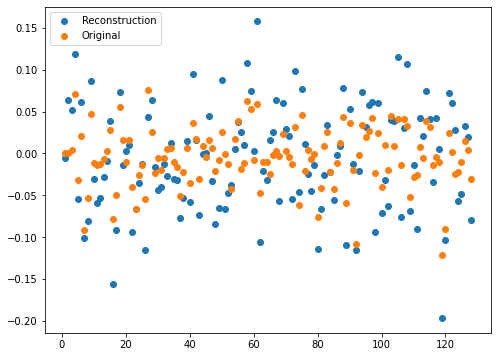

In [49]:
plt.scatter(x_axis, validate[0,:])
plt.scatter(x_axis, validate_decoder[0,0,:])

plt.legend(['Reconstruction','Original'],loc='upper left')

# Verify w/ Lv1...

In [71]:
temp4 = np.zeros([1,Lv2_latent_dim])
temp4[0,:] = Lv2_latent[0,:]

Lv1_latent_decoded = Decoder(temp4)*AT+mean

In [72]:
Lv2_latent.shape

(10, 128)

In [73]:
Lv1_latent_decoded.shape

TensorShape([1, 200, 128])

In [74]:
filename2='test_constrained_ae/decoder_%d.h5' % (epoch_1)
Decoder_Lv1 = load_model(filename2)
Decoder_Lv1.summary()

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1830400)           236121600 
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1830400)           0         
_________________________________________________________________
reshape (Reshape)            (None, 14300, 128)        0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 14300, 256)        131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14300, 256)        1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14300, 256)        0   

In [75]:
temp5 = np.zeros([1, Lv1_latent_dim])
temp6 = np.zeros([num_time, num_node, num_var])

for i in range(num_time):
    temp5[0,:] = Lv1_latent_decoded[0,i,:]
    Lv1_decoded = Decoder_Lv1(temp5)
    temp6[i,:,:]=Lv1_decoded[0,:,:]
    


In [76]:
Lv1_decoded.shape

TensorShape([1, 14300, 4])

In [77]:
temp6.shape

(200, 14300, 4)

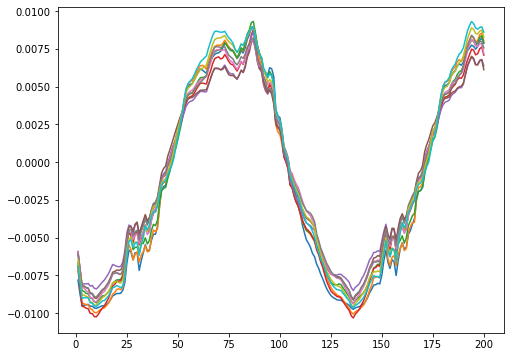

In [82]:
x_axis11 = np.linspace(1,num_time, num_time)

for i in range(10):
    plt.plot(x_axis11, temp6[:,i,3])

# Parametric interpolation in the latent space

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.


In [58]:
Lv2_latent.shape

(10, 128)

In [59]:
interp_latent = (Lv2_latent[interp1,:]+Lv2_latent[interp2,:])/2 #parameteric interpolation
interp_latent = interp_latent.reshape(1, -1)

interp_latent.shape

(1, 128)

In [60]:
interp_Lv1_latent = Decoder(interp_latent, training=False)

interp_Lv1_latent.shape

TensorShape([1, 200, 128])

In [61]:
# Unscale

In [62]:
interp_Lv1_latent = (interp_Lv1_latent*AT)+mean

In [63]:
print(interp_Lv1_latent[0,0,0], f[0,0,0])

tf.Tensor(-15.303832, shape=(), dtype=float32) -0.005187904080238464


In [64]:
filename4 = 'interpolated_latentcode'

np.savetxt(filename4, interp_Lv1_latent[0,:,:], fmt = '%f')

In [65]:
pause;

NameError: name 'pause' is not defined